<a href="https://colab.research.google.com/github/skywalker0803r/AlphaCoin/blob/main/cnn%E6%AF%94%E7%89%B9%E5%B9%A3%E5%BE%85%E8%AA%BF%E5%8F%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 套件設置

In [207]:
#!pip install yfinance
#!pip install finta

In [208]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf
from datetime import datetime, timedelta
import math
from finta import TA
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
seed = 89
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# 參數

In [209]:
y_symbol = "BTC-USD" # 股票代碼 ^TWII 台灣加權指數 美股蘋果 AAPL 台股台積電 2330.TW
startdate = datetime(2013,1,1) # 訓練起始日期
enddate = datetime(2023,1,1) # 訓練結束日期
漲幅  = 1.01 # 漲3%出場
跌幅 = 0.99 # 跌3%出場
持有時間 = 1 #預期要持有多長時間
period1 = 6
period2 = 20
test_set_size = 90
樣本時間長度  = 7
樣本特徵長度 = 7

# 載入資料

In [210]:
def load_data(y_symbol,startdate,enddate):
    df = yf.download(y_symbol, start = startdate,end = enddate)
    df.columns = [col[0] for col in df.columns]
    return df
df = load_data(y_symbol,startdate,enddate)
display(df)

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
...,...,...,...,...,...
2022-12-27,16717.173828,16959.845703,16642.072266,16919.291016,15748580239
2022-12-28,16552.572266,16768.169922,16497.556641,16716.400391,17005713920
2022-12-29,16642.341797,16651.755859,16508.683594,16552.322266,14472237479


# Label triple_barrier

,Close,High,Low,Open,Volume,triple_barrier_signal
Date,,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800,-1
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,-1
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,1
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,-1
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,0
...,...,...,...,...,...,...
2022-12-26,16919.804688,16920.123047,16812.369141,16842.250000,11886957804,-1
2022-12-27,16717.173828,16959.845703,16642.072266,16919.291016,15748580239,0
2022-12-28,16552.572266,16768.169922,16497.556641,16716.400391,17005713920,0


triple_barrier_signal
 0    1118
 1    1040
-1     869
Name: count, dtype: int64


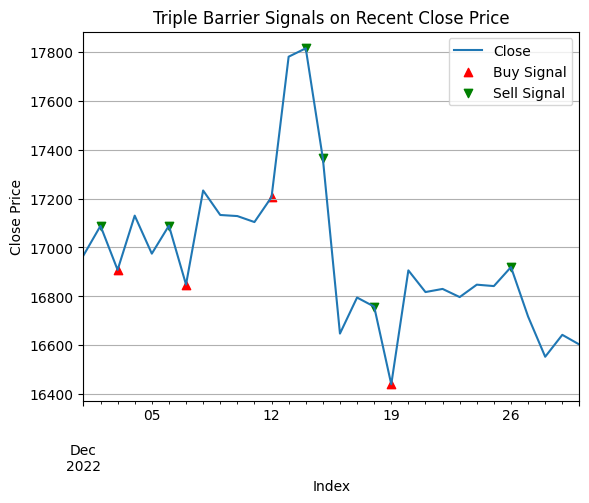

In [211]:
def triple_barrier_signal(price, ub, lb, t):
    signal = []
    ub = float(ub)
    lb = float(lb)

    # Ensure price is a 1D numpy array of floats
    # This step is crucial to prevent DTypePromotionError if 'price' contains mixed types
    price = np.asarray(price, dtype=np.float64)

    for i in range(len(price) - t):
        current_price = price[i] # price is already a 1D array of floats
        slice_prices = price[i:i+t+1] # Slicing a NumPy array directly

        if np.max(slice_prices) > current_price * ub:
            signal.append(1)
        elif np.min(slice_prices) < current_price * lb:
            signal.append(-1)
        else:
            signal.append(0)
    return signal

def add_triple_barrier_signal(df, 漲幅, 跌幅, 持有時間):
    # Convert 'Close' column to a NumPy array of floats explicitly
    # This is the key change to prevent the DTypePromotionError
    close_prices_array = df.Close.values.astype(np.float64)

    ret = triple_barrier_signal(close_prices_array, 漲幅, 跌幅, 持有時間)

    # Ensure the DataFrame is sliced correctly to match the length of `ret`
    # This avoids issues if `len(ret)` is shorter than `df` due to `t`
    df_sliced = df.iloc[:len(ret)].copy() # Use .iloc and .copy() to prevent SettingWithCopyWarning
    df_sliced['triple_barrier_signal'] = ret
    return df_sliced

df = add_triple_barrier_signal(df,漲幅,跌幅,持有時間)

# 展示加入訊號後的df
display(df)
print(df['triple_barrier_signal'].value_counts())

# 繪製訊號買賣點
plt.clf() # Clear the current figure before drawing
df_recent = df.tail(30)
buy = df_recent[df_recent['triple_barrier_signal']==1]['Close']
sell = df_recent[df_recent['triple_barrier_signal']==-1]['Close']
df_recent['Close'].plot()
plt.scatter(buy.index,buy.values,color='red',marker='^', label='Buy Signal')
plt.scatter(sell.index,sell.values,color='green',marker='v', label='Sell Signal')
plt.title('Triple Barrier Signals on Recent Close Price')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# 假設有個神能知道未來用Label triple_barrier提前知道買賣點

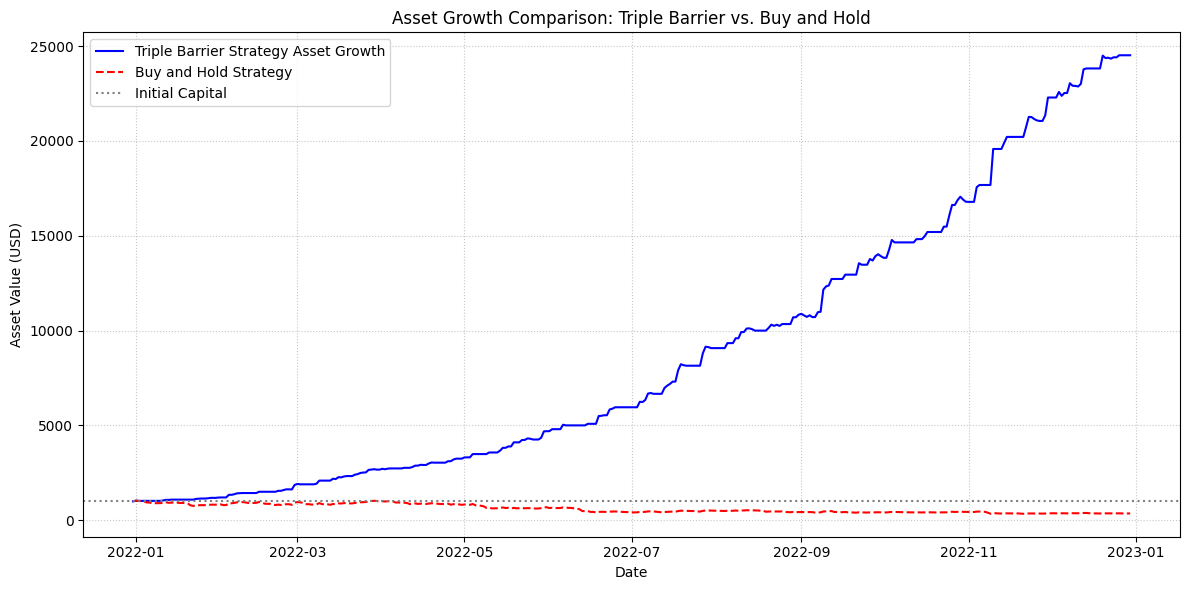


--- Strategy Simulation Summary ---
Initial Capital: $1000.00
Final Triple Barrier Asset Value: $24516.53
Triple Barrier Total Return: 2351.65%

--- Buy and Hold Simulation Summary ---
Final Buy and Hold Asset Value: $358.54
Buy and Hold Total Return: -64.15%


In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 計算資產成長曲線函數
def calculate_Asset_Growth(df, initial_capital=1000):
    # --- Strategy Simulation ---
    cash = float(initial_capital)  # Ensure initial cash is a float
    shares = 0.0  # Ensure shares starts as a float
    asset_values = []  # To store the asset value at each step

    for i in range(len(df)):
        current_price = df['Close'].iloc[i]
        signal = df['triple_barrier_signal'].iloc[i]

        if signal == 1: # Buy signal
            if cash > 0:
                shares_to_buy = float(cash) / float(current_price)
                shares += shares_to_buy
                cash = 0.0
        elif signal == -1: # Sell signal
            if shares > 0.0:
                cash_from_sell = float(shares) * float(current_price)
                cash += cash_from_sell
                shares = 0.0
        # If signal is 0, do nothing

        current_asset_value = cash + (shares * current_price)
        asset_values.append(current_asset_value)

    df_copy = df.copy() # Work on a copy to avoid SettingWithCopyWarning if df is a slice
    df_copy['asset_value'] = asset_values

    # --- Calculate Buy and Hold Strategy ---
    buy_and_hold_asset_values = []
    # Buy as many shares as possible on the first day
    first_price = df_copy['Close'].iloc[0]
    initial_shares_held = float(initial_capital) / float(first_price)

    for i in range(len(df_copy)):
        current_price_bh = df_copy['Close'].iloc[i]
        # Asset value is shares held multiplied by current price
        buy_and_hold_asset_values.append(initial_shares_held * current_price_bh)

    df_copy['buy_and_hold_asset_value'] = buy_and_hold_asset_values


    # --- Plotting Asset Growth ---
    plt.figure(figsize=(12, 6))
    plt.plot(df_copy.index, df_copy['asset_value'], label='Triple Barrier Strategy Asset Growth', color='blue')
    # Plotting the Buy and Hold Strategy
    plt.plot(df_copy.index, df_copy['buy_and_hold_asset_value'], label='Buy and Hold Strategy', color='red', linestyle='--')
    plt.axhline(y=initial_capital, color='grey', linestyle=':', label='Initial Capital')
    plt.title('Asset Growth Comparison: Triple Barrier vs. Buy and Hold')
    plt.xlabel('Date')
    plt.ylabel('Asset Value (USD)')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n--- Strategy Simulation Summary ---")
    print(f"Initial Capital: ${initial_capital:.2f}")
    print(f"Final Triple Barrier Asset Value: ${df_copy['asset_value'].iloc[-1].item():.2f}")
    print(f"Triple Barrier Total Return: {(df_copy['asset_value'].iloc[-1].item() / initial_capital - 1) * 100:.2f}%")

    print("\n--- Buy and Hold Simulation Summary ---")
    print(f"Final Buy and Hold Asset Value: ${df_copy['buy_and_hold_asset_value'].iloc[-1].item():.2f}")
    print(f"Buy and Hold Total Return: {(df_copy['buy_and_hold_asset_value'].iloc[-1].item() / initial_capital - 1) * 100:.2f}%")

# 使用資產成長曲線函數
calculate_Asset_Growth(df.tail(365), initial_capital=1000)

# 製作特徵

In [213]:
df[f'RSI_{period1}'] = TA.RSI(df, period=period1)
df[f'RSI_{period2}'] = TA.RSI(df, period=period2)
df

,Close,High,Low,Open,Volume,triple_barrier_signal,RSI_6,RSI_20
Date,,,,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800,-1,NaN,NaN
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,-1,0.000000,0.000000
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,1,0.000000,0.000000
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,-1,22.882389,19.606249
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,0,19.128461,17.086045
...,...,...,...,...,...,...,...,...
2022-12-26,16919.804688,16920.123047,16812.369141,16842.250000,11886957804,-1,52.777978,47.182169
2022-12-27,16717.173828,16959.845703,16642.072266,16919.291016,15748580239,0,40.039352,45.050338
2022-12-28,16552.572266,16768.169922,16497.556641,16716.400391,17005713920,0,32.413258,43.374566


In [214]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from finta import TA # Import the TA object from finta
import warnings
warnings.filterwarnings('ignore') # Suppress warnings, though generally good to review them

def calculate_pzo(df, period=14, smooth_period=None):
    """
    計算 Price Zone Oscillator (PZO)。

    參數:
    df (pd.DataFrame): 包含 'High', 'Low', 'Close', 'Volume' 列的 DataFrame。
    period (int): PZO 計算的週期 (通常為 14)。
    smooth_period (int, optional): 用於平滑 PZO 的移動平均線週期。如果為 None，則不進行平滑。

    返回:
    pd.Series: 包含 PZO 值的 Series。
    """
    df_copy = df.copy()

    # 1. 計算典型價格 (Typical Price)
    df_copy['TP'] = (df_copy['High'] + df_copy['Low'] + df_copy['Close']) / 3

    # 2. 計算加權成交量 (Weighted Volume)
    df_copy['WV'] = df_copy['TP'] * df_copy['Volume']

    # 3. 計算價格趨勢 (Price Trend)
    df_copy['TP_prev'] = df_copy['TP'].shift(1) # 前一日的典型價格

    # 初始化 'PT' 列
    df_copy['PT'] = 0.0

    # 根據價格趨勢賦值
    df_copy.loc[df_copy['TP'] > df_copy['TP_prev'], 'PT'] = df_copy['WV']
    df_copy.loc[df_copy['TP'] < df_copy['TP_prev'], 'PT'] = -df_copy['WV']
    # 如果 TP == TP_prev, PT 保持為 0.0

    # 4. 計算累積價格趨勢 (Cumulative Price Trend) 的滾動總和
    df_copy['CPT'] = df_copy['PT'].rolling(window=period).sum()

    # 5. 計算累積加權成交量 (Cumulative Weighted Volume) 的滾動總和
    df_copy['CWV'] = df_copy['WV'].rolling(window=period).sum()

    # 6. 計算 PZO
    # 處理 CWV 為零的情況，避免除以零
    df_copy['PZO'] = np.where(df_copy['CWV'] == 0, 0, (df_copy['CPT'] / df_copy['CWV']) * 100)

    # 7. 平滑 PZO (可選)
    if smooth_period is not None:
        df_copy['PZO_Smoothed'] = df_copy['PZO'].rolling(window=smooth_period).mean() # 或 .ewm(span=smooth_period, adjust=False).mean()
        return df_copy['PZO_Smoothed']
    else:
        return df_copy['PZO']

# 修改 generate_finta_indicators 函數以整合 PZO
def generate_finta_indicators(df, periods=[6,20], pzo_smooth_period=None):
    df_copy = df.copy()
    indicator_functions = {
        "RSI": TA.RSI,
        "WPR": TA.WILLIAMS,
        "WMA": TA.WMA,
        "EMA": TA.EMA,
        "SMA": TA.SMA,
        "HMA": TA.HMA,
        "TEMA": TA.TEMA,
        "CCI": TA.CCI,
        "CMO": TA.CMO,
        #"MACD": TA.MACD,
        #"PPO": TA.PPO,
        "ROC": TA.ROC, # Rate of Change (ROC)
        "CHAIKIN_OSC": TA.CHAIKIN,
        "DMI": TA.DMI, # Directional Movement Index (usually returns ADX, DI+, DI-)
        # "PSI": TA.PSI, # 此行已移除，因為 finta 中沒有 TA.PSI，並用自定義的 PZO 取代
    }
    single_call_indicators = {
        "MACD": TA.MACD,
        "PPO": TA.PPO,
    }

    print(f"Calculating Finta indicators for periods: {periods}")
    for indicator_name, func in indicator_functions.items():
        for period in periods:
            col_name = f"{indicator_name}_{period}"
            try:
                if indicator_name in ["MACD", "PPO", "DMI"]:
                    # 這些多輸出指標，finta 通常會使用其內部預設週期，
                    # 除非明確傳遞多個週期參數。這裡保持單一 period 傳遞，
                    # 如果 finta 支援，則該 period 會被使用。
                    result = func(df_copy, period=period)
                    if isinstance(result, pd.DataFrame):
                        for sub_col in result.columns:
                            df_copy[f"{indicator_name}_{sub_col}_{period}"] = result[sub_col]
                    else: # Fallback if for some reason it returns a Series
                         df_copy[f"{indicator_name}_{period}"] = result
                elif indicator_name in ["CHAIKIN_OSC", "ADL"]:
                    # 這些指標在 finta 中不接受 'period' 參數，只計算一次。
                    if f"{indicator_name}" not in df_copy.columns: # Calculate only once
                        df_copy[indicator_name] = func(df_copy)
                    # 不再為這些指標添加週期後綴，因為它們不依賴於 'period'
                elif indicator_name == "MFI":
                    # MFI 確實接受 'period' 參數，所以回歸到一般處理
                    df_copy[col_name] = func(df_copy, period=period)
                else: # 對於所有其他接受 'period' 並返回單一序列的指標
                    df_copy[col_name] = func(df_copy, period=period)

            except Exception as e:
                print(f"    - WARNING: Could not calculate {col_name}: {e}")
                df_copy[col_name] = np.nan

    print("Calculating Finta single-call/complex indicators:")
    for indicator_name, func in single_call_indicators.items():
        try:
            result = func(df_copy) # Call without 'period' to use defaults
            if isinstance(result, pd.DataFrame):
                # For indicators like MACD, PPO, DMI that return multiple columns
                for sub_col in result.columns:
                    df_copy[f"{indicator_name}_{sub_col}"] = result[sub_col]
            else: # Fallback if for some reason it returns a Series
                df_copy[f"{indicator_name}"] = result
        except Exception as e:
            print(f"     - WARNING: Could not calculate {indicator_name}: {e}")
            # If a multi-output indicator fails, ensure its expected columns are still added as NaN
            if indicator_name == "MACD":
                df_copy['MACD'] = np.nan
                df_copy['SIGNAL'] = np.nan
                df_copy['HISTO'] = np.nan
            elif indicator_name == "PPO":
                df_copy['PPO'] = np.nan
                df_copy['SIGNAL'] = np.nan
                df_copy['HISTO'] = np.nan
            # Add similar logic for other multi-output indicators if they are moved here

    # 在此處整合自定義的 PZO 計算
    print(f"Calculating custom PZO indicators for periods: {periods}")
    for period in periods:
        pzo_col_name = f"PZO_{period}"
        if pzo_smooth_period is not None:
            pzo_col_name += f"_S{pzo_smooth_period}" # 如果有平滑，添加平滑週期到列名
        try:
            df_copy[pzo_col_name] = calculate_pzo(df_copy, period=period, smooth_period=pzo_smooth_period)
        except Exception as e:
            print(f"    - WARNING: Could not calculate {pzo_col_name}: {e}")
            df_copy[pzo_col_name] = np.nan

    # 清理任何可能由技術分析計算引起的正負無限大值
    df_copy.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df_copy

df_with_indicators = generate_finta_indicators(df, periods=[6,20])
df_with_indicators

Calculating Finta indicators for periods: [6, 20]
Calculating Finta single-call/complex indicators:
Calculating custom PZO indicators for periods: [6, 20]


,Close,High,Low,Open,Volume,triple_barrier_signal,RSI_6,RSI_20,WPR_6,WPR_20,...,DMI_DI-_6,DMI_DI+_20,DMI_DI-_20,MACD_MACD,MACD_SIGNAL,PPO_PPO,PPO_SIGNAL,PPO_HISTO,PZO_6,PZO_20
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200,-1,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,-0.738007,-0.410004,-0.167632,-0.093129,-0.074503,NaN,NaN
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700,1,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,-1.859626,-1.004111,-0.438672,-0.234745,-0.203927,NaN,NaN
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600,-1,22.882389,19.606249,NaN,NaN,...,NaN,NaN,NaN,-1.814822,-1.278742,-0.432385,-0.301696,-0.130689,NaN,NaN
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100,0,19.128461,17.086045,NaN,NaN,...,NaN,NaN,NaN,-2.153494,-1.538961,-0.519069,-0.366360,-0.152709,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,16919.804688,16920.123047,16812.369141,16842.250000,11886957804,-1,52.777978,47.182169,-0.097145,-72.835375,...,17.611838,19.427411,23.846007,-96.481656,-102.628407,-0.567982,-0.602399,0.034417,29.860181,2.750940
2022-12-27,16717.173828,16959.845703,16642.072266,16919.291016,15748580239,0,40.039352,45.050338,-66.044395,-83.386898,...,31.930009,18.456040,25.269295,-103.142239,-102.731173,-0.607907,-0.603501,-0.004406,-8.320020,3.943071
2022-12-28,16552.572266,16768.169922,16497.556641,16716.400391,17005713920,0,32.413258,43.374566,-88.099302,-91.958134,...,41.304193,17.533238,26.298884,-120.315843,-106.248107,-0.710411,-0.624883,-0.085528,-8.775684,-6.867754


# 定義出x_col y_col

In [215]:
x_col = set(df_with_indicators.columns) - set(['Close','High','Low','Open','triple_barrier_signal','Volume'])
x_col = list(x_col)
x_col
y_col = 'triple_barrier_signal'
x_col,y_col

(['CCI_20',
  'PPO_SIGNAL',
  'DMI_DI+_6',
  'RSI_6',
  'WPR_6',
  'SMA_6',
  'TEMA_20',
  'PZO_20',
  'MACD_MACD',
  'MACD_SIGNAL',
  'CCI_6',
  'WMA_20',
  'RSI_20',
  'DMI_DI-_20',
  'HMA_20',
  'PPO_HISTO',
  'HMA_6',
  'CMO_6',
  'ROC_6',
  'ROC_20',
  'PZO_6',
  'TEMA_6',
  'EMA_6',
  'WPR_20',
  'DMI_DI+_20',
  'DMI_DI-_6',
  'WMA_6',
  'CHAIKIN_OSC',
  'CMO_20',
  'EMA_20',
  'SMA_20',
  'PPO_PPO'],
 'triple_barrier_signal')

# 這時數據很大還不能用

In [216]:
df_with_indicators[x_col].describe().T[['min','max']].sort_values(by='max',ascending=False)

,min,max
CHAIKIN_OSC,-6.846014e+10,1.198382e+11
HMA_6,1.826672e+02,6.773847e+04
TEMA_6,1.939254e+02,6.704555e+04
HMA_20,1.897582e+02,6.584159e+04
SMA_6,2.034173e+02,6.551822e+04
WMA_6,2.048724e+02,6.540215e+04
TEMA_20,1.963441e+02,6.533933e+04
EMA_6,2.138386e+02,6.482675e+04
WMA_20,2.256952e+02,6.395342e+04
EMA_20,2.286691e+02,6.320830e+04


<Axes: xlabel='Date'>

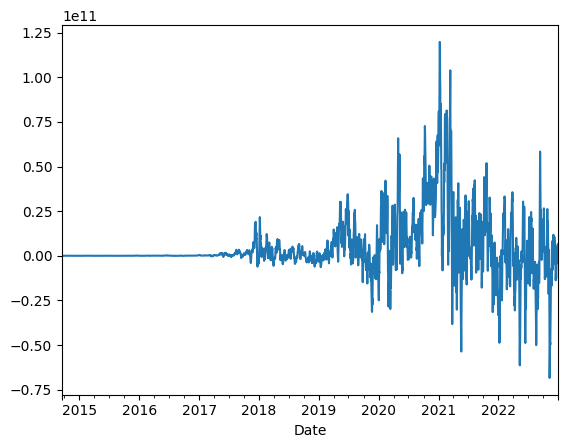

In [217]:
df_with_indicators['CHAIKIN_OSC'].plot()

# 特徵預處理

In [218]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib # 推薦使用 joblib 而非 pickle，對 scikit-learn 物件兼容性更好

def preprocess_indicators(df: pd.DataFrame, scaler=None, fit_scaler: bool = True) -> (pd.DataFrame, StandardScaler):
    """
    預處理金融技術指標，使其適合機器學習模型（特別是神經網路）。

    此函數將對 DataFrame 中的特定技術指標進行以下處理：
    1. 對於會隨價格絕對值變化的指標（如原始價格、移動平均線、蔡金震盪指標），
       計算其百分比變化。
    2. 對於 MACD 相關指標（可能跨越零點），計算其一階差分。
    3. 對於所有用於模型輸入的數值型特徵，應用 Z-score 標準化。
    4. triple_barrier_signal 列會被保留，但不會被標準化（假設為目標變量）。

    Args:
        df (pd.DataFrame): 包含原始技術指標的 DataFrame。
                         需要至少包含以下列，或其子集：
                         'Close', 'High', 'Low', 'Open', 'Volume',
                         'WMA_6', 'WMA_20', 'EMA_6', 'EMA_20', 'SMA_6', 'SMA_20',
                         'HMA_6', 'HMA_20', 'TEMA_6', 'TEMA_20',
                         'MACD_MACD', 'MACD_SIGNAL', 'CHAIKIN_OSC',
                         'RSI_6', 'RSI_20', 'WPR_6', 'WPR_20', 'CCI_6', 'CCI_20',
                         'CMO_6', 'CMO_20', 'ROC_6', 'ROC_20',
                         'DMI_DI+_6', 'DMI_DI-_6', 'DMI_DI+_20', 'DMI_DI-_20',
                         'PPO_PPO', 'PPO_SIGNAL', 'PPO_HISTO', 'PZO_6', 'PZO_20',
                         'triple_barrier_signal'
        scaler (StandardScaler, optional): 預訓練的 StandardScaler 物件。
                                         如果在推論階段，傳入此物件以進行轉換。
                                         如果在訓練階段，則為 None。
        fit_scaler (bool, optional): 是否在函數內部訓練新的 StandardScaler。
                                   通常在訓練階段設為 True，推論階段設為 False。
                                   默認為 True。

    Returns:
        tuple[pd.DataFrame, StandardScaler]:
            pd.DataFrame: 經過處理後的 DataFrame，適合直接用於機器學習模型。
                          包含處理後的特徵和目標變量，並已處理 NaN 值。
            StandardScaler: 訓練好的 StandardScaler 物件（如果 fit_scaler=True）
                            或傳入的 scaler 物件（如果 fit_scaler=False）。
    """

    df_processed = df.copy() # 避免修改原始 DataFrame

    # --- 1. 定義不同處理方式的指標列表 ---
    pct_change_cols = [
        'Close', 'High', 'Low', 'Open', 'Volume',
        'WMA_6', 'WMA_20', 'EMA_6', 'EMA_20', 'SMA_6', 'SMA_20',
        'HMA_6', 'HMA_20', 'TEMA_6', 'TEMA_20', 'CHAIKIN_OSC'
    ]
    diff_cols = [
        'MACD_MACD', 'MACD_SIGNAL'
    ]
    direct_standardize_cols = [
        'RSI_6', 'RSI_20', 'WPR_6', 'WPR_20', 'CCI_6', 'CCI_20',
        'CMO_6', 'CMO_20', 'ROC_6', 'ROC_20',
        'DMI_DI+_6', 'DMI_DI-_6', 'DMI_DI+_20', 'DMI_DI-_20',
        'PPO_PPO', 'PPO_SIGNAL', 'PPO_HISTO', 'PZO_6', 'PZO_20'
    ]

    final_features = []

    # 保留 triple_barrier_signal (假設為目標變量)
    if 'triple_barrier_signal' in df_processed.columns:
        final_features.append('triple_barrier_signal')

    # --- 2. 執行百分比變化處理 ---
    for col in pct_change_cols:
        if col in df_processed.columns:
            new_col_name = col # 保持原名，因為原始列會被移除
            df_processed[new_col_name] = df_processed[col].pct_change() * 100
            final_features.append(new_col_name)

    # --- 3. 執行一階差分處理 ---
    for col in diff_cols:
        if col in df_processed.columns:
            new_col_name = col # 保持原名
            df_processed[new_col_name] = df_processed[col].diff()
            final_features.append(new_col_name)

    # --- 4. 添加直接標準化的指標 ---
    for col in direct_standardize_cols:
        if col in df_processed.columns:
            final_features.append(col)

    # --- 5. 構建最終的特徵 DataFrame 並處理 NaN 值 ---
    df_final_features = df_processed[final_features].copy()

    # 處理差分和百分比變化帶來的 NaN 值
    df_final_features.dropna(inplace=True)

    # --- 6. 對所有數值型特徵進行標準化 ---
    features_to_scale = [col for col in df_final_features.columns if col != 'triple_barrier_signal']

    if features_to_scale:
        if fit_scaler: # 訓練模式
            scaler = StandardScaler()
            df_final_features[features_to_scale] = scaler.fit_transform(df_final_features[features_to_scale])
        else: # 推論模式
            if scaler is None:
                raise ValueError("在推論模式下 (fit_scaler=False)，必須提供一個預訓練的 scaler 物件。")
            df_final_features[features_to_scale] = scaler.transform(df_final_features[features_to_scale])
    else:
        print("警告: 沒有找到需要標準化的特徵。請檢查輸入數據和列名。")

    return df_final_features, scaler

df_with_indicators,scaler_trained = preprocess_indicators(df_with_indicators)
joblib.dump(scaler_trained, 'trained_scaler.joblib')
df_with_indicators[x_col].describe().T

,count,mean,std,min,25%,50%,75%,max
CCI_20,3004.0,-9.461288e-18,1.000166,-4.344924,-0.732084,0.029975,0.762447,4.188376
PPO_SIGNAL,3004.0,1.892258e-17,1.000166,-2.858130,-0.589868,-0.066890,0.583246,3.864894
DMI_DI+_6,3004.0,-9.461288e-18,1.000166,-1.432746,-0.749849,-0.249470,0.498533,5.407564
RSI_6,3004.0,-4.730644e-17,1.000166,-2.501863,-0.749956,-0.059324,0.736506,2.360937
WPR_6,3004.0,-2.838386e-17,1.000166,-1.789038,-0.888605,0.082030,0.935392,1.490405
SMA_6,3004.0,2.365322e-17,1.000166,-5.376829,-0.490764,-0.018565,0.501347,6.083462
TEMA_20,3004.0,7.095966e-18,1.000166,-6.552135,-0.463877,-0.011834,0.500123,7.593388
PZO_20,3004.0,0.000000e+00,1.000166,-3.084075,-0.753982,0.004359,0.721921,2.884046
MACD_MACD,3004.0,-8.814520e-18,1.000166,-7.554568,-0.084253,0.003354,0.170775,6.669545
MACD_SIGNAL,3004.0,4.250188e-18,1.000166,-6.338303,-0.104301,0.003651,0.175746,4.883404


# 繪製特徵分布圖

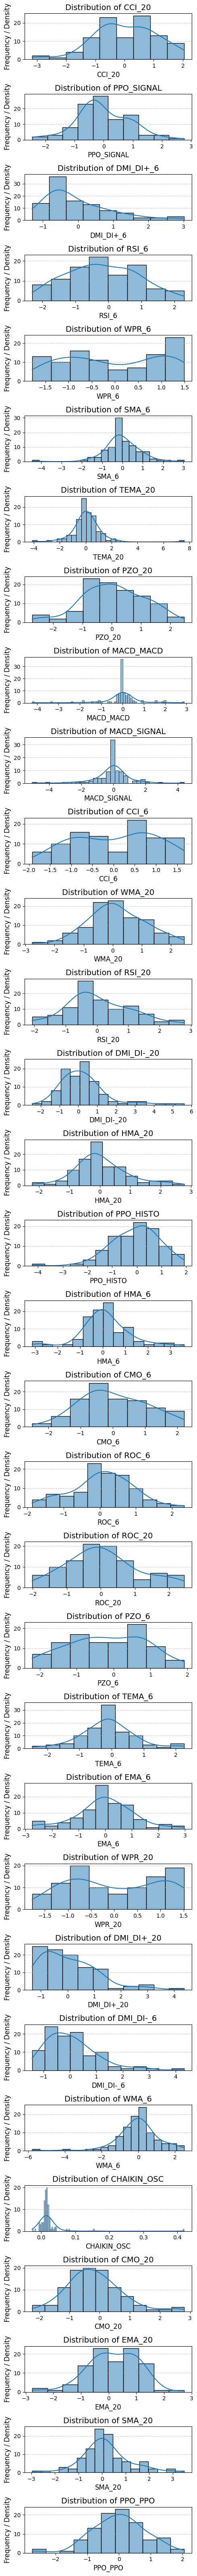

In [219]:
plt.figure(figsize=(5, 2 * len(x_col)))
for i, col in enumerate(x_col):
    plt.subplot(len(x_col), 1, i + 1)
    sns.histplot(df_with_indicators[col].dropna().sample(100), kde=True, bins='auto')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency / Density', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7) # 增加網格線
plt.tight_layout()
plt.show()

# 做anova分析

對目標欄位 'triple_barrier_signal' 進行 ANOVA 分析:
------------------------------

分析技術指標: 'CCI_20'
  F 統計量: 2.7685
  P 值: 0.0629
------------------------------

分析技術指標: 'PPO_SIGNAL'
  F 統計量: 6.0636
  P 值: 0.0024
------------------------------

分析技術指標: 'DMI_DI+_6'
  F 統計量: 7.3895
  P 值: 0.0006
------------------------------

分析技術指標: 'RSI_6'
  F 統計量: 1.3510
  P 值: 0.2591
------------------------------

分析技術指標: 'WPR_6'
  F 統計量: 0.4005
  P 值: 0.6700
------------------------------

分析技術指標: 'SMA_6'
  F 統計量: 0.0220
  P 值: 0.9782
------------------------------

分析技術指標: 'TEMA_20'
  F 統計量: 0.3303
  P 值: 0.7187
------------------------------

分析技術指標: 'PZO_20'
  F 統計量: 4.3097
  P 值: 0.0135
------------------------------

分析技術指標: 'MACD_MACD'
  F 統計量: 2.8607
  P 值: 0.0574
------------------------------

分析技術指標: 'MACD_SIGNAL'
  F 統計量: 0.5262
  P 值: 0.5909
------------------------------

分析技術指標: 'CCI_6'
  F 統計量: 1.2184
  P 值: 0.2959
------------------------------

分析技術指標: 'WMA_20'
  F 統計量: 1.3621
  P 值: 0.25

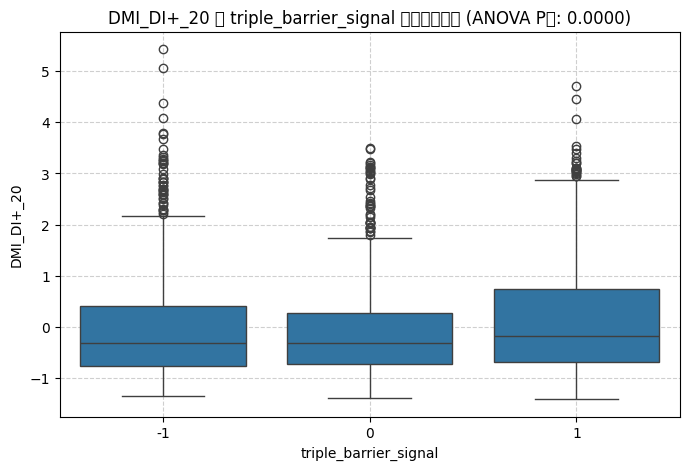

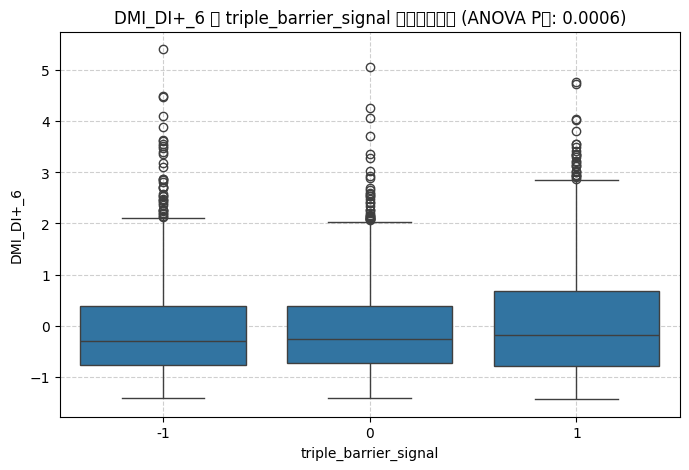

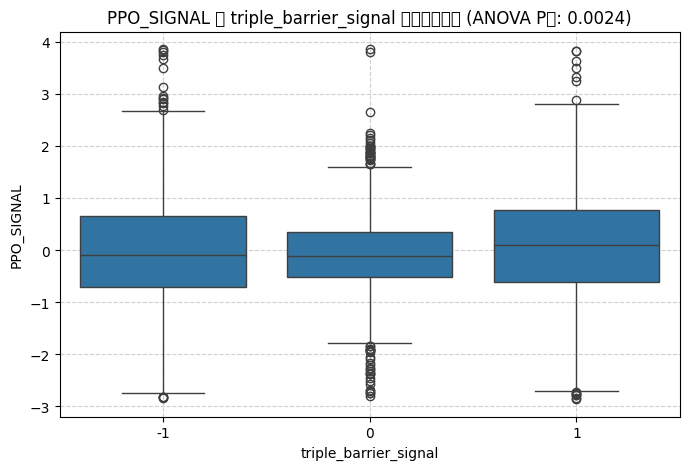

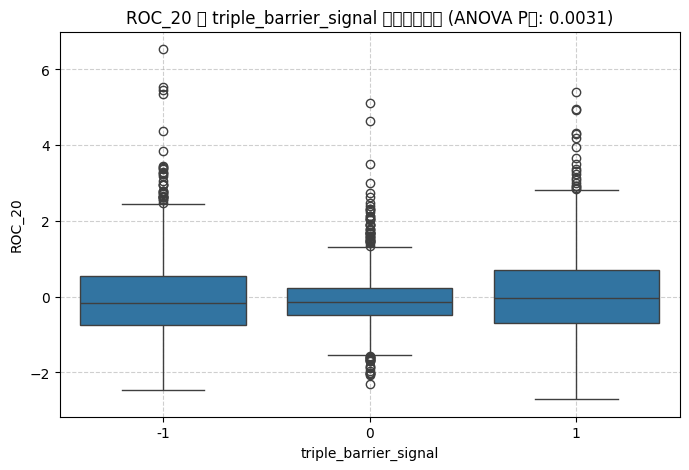

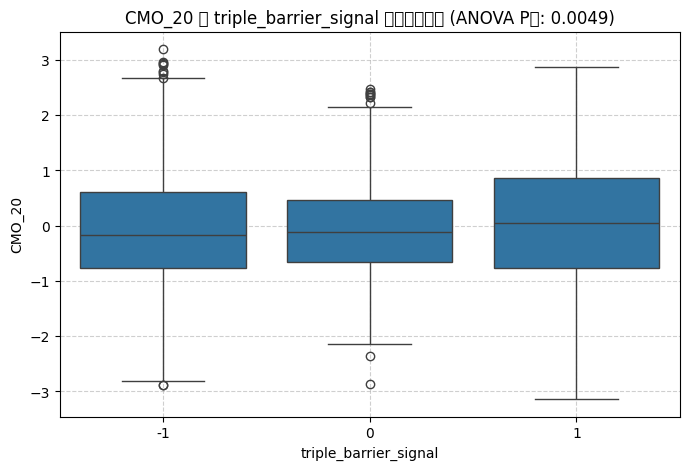

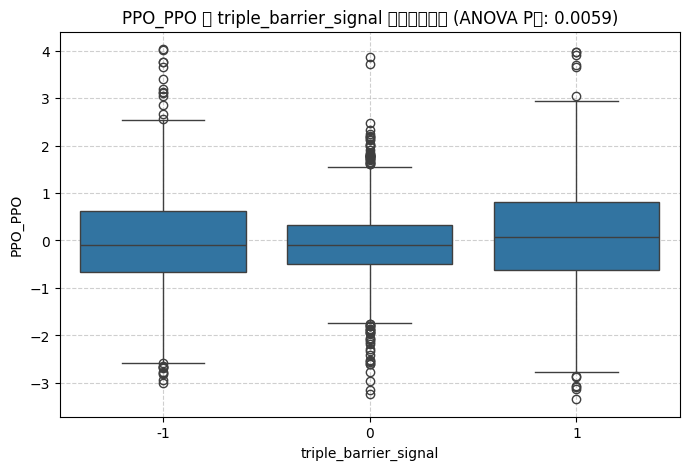

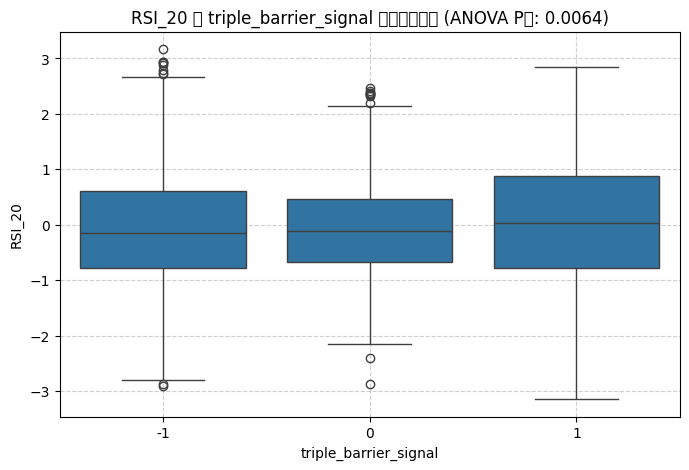

x_col 32
significant_features 7


In [220]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

def Anova(df, x_cols, y_col, top_n=樣本特徵長度):
    """
    Performs ANOVA analysis on specified independent variables (x_cols) against
    a dependent categorical variable (y_col) and returns the top N most significant features.

    Args:
        df (pd.DataFrame): The input DataFrame containing all columns.
        x_cols (list): A list of column names (technical indicators) to analyze.
        y_col (str): The name of the target categorical column (e.g., 'Signal').
        top_n (int, optional): The number of top features to retain based on p-value.
                                If None, all significant features (p < alpha) are returned.
                                If an integer, the top_n features with the smallest p-values are returned.

    Returns:
        list: A list of column names for the top N significant features.
    """
    print(f"對目標欄位 '{y_col}' 進行 ANOVA 分析:")
    print("-" * 30)

    anova_results = {}

    for x_col in x_cols:
        # Filter out NaN values for the current x_col and y_col to avoid issues
        temp_df = df[[x_col, y_col]].dropna()

        # Check if there are enough unique categories or data points for ANOVA
        if len(temp_df[y_col].unique()) < 2:
            print(f"警告: '{y_col}' 在 '{x_col}' 的數據中只有少於2個類別，跳過 ANOVA。")
            continue
        if len(temp_df[x_col].unique()) < 2:
            print(f"警告: '{x_col}' 的數據變化不足，跳過 ANOVA。")
            continue

        # 將目標變數的各個類別分組
        groups = [temp_df[x_col][temp_df[y_col] == category] for category in temp_df[y_col].unique()]

        # 執行單因子 ANOVA 檢定
        try:
            f_statistic, p_value = stats.f_oneway(*groups)
        except ValueError as e:
            print(f"錯誤: 執行 ANOVA 時發生問題，可能是組別數據不足。跳過 '{x_col}'。錯誤訊息: {e}")
            continue

        anova_results[x_col] = {'F_statistic': f_statistic, 'P_value': p_value}

        print(f"\n分析技術指標: '{x_col}'")
        print(f"  F 統計量: {f_statistic:.4f}")
        print(f"  P 值: {p_value:.4f}")
        print("-" * 30)

    # Convert results to DataFrame for sorting
    results_df = pd.DataFrame.from_dict(anova_results, orient='index')

    if results_df.empty:
        print("沒有可用的 ANOVA 結果，可能是因為數據問題。")
        return []

    # Sort by P_value in ascending order (smaller p-value means more significant)
    results_df = results_df.sort_values(by='P_value', ascending=True)

    # Add a 'Significant' column based on a default alpha, even if not directly used for top_n selection
    alpha = 0.05
    results_df['Significant'] = results_df['P_value'] < alpha

    print("\n--- ANOVA 分析結果摘要 (按P值排序) ---")
    print(results_df)

    retained_features = []
    if top_n is not None:
        # Select the top N features based on the sorted P-values
        retained_features = results_df.head(top_n).index.tolist()
        print(f"\n根據 ANOVA 分析，保留前 {top_n} 個最顯著的技術指標: {retained_features}")
    else:
        # If top_n is None, revert to original behavior (all features below alpha)
        retained_features = results_df[results_df['Significant'] == True].index.tolist()
        print(f"\n根據 ANOVA 分析，建議保留的顯著技術指標 (P < {alpha}): {retained_features}")


    # --- 視覺化 ANOVA 結果 (可選) ---
    print("\n--- 視覺化 ANOVA 結果 ---")

    # Only plot for the retained features
    features_to_plot = retained_features if top_n is not None else results_df.index.tolist() # Plot all if no top_n specified
    if top_n is not None: # If top_n is specified, only plot the top_n
        features_to_plot = retained_features
    else: # Otherwise, plot all that were analyzed
        features_to_plot = results_df.index.tolist()


    for x_col in features_to_plot:
        # Ensure we only plot if the feature had a result
        if x_col in anova_results:
            plt.figure(figsize=(8, 5))
            sns.boxplot(x=y_col, y=x_col, data=df.dropna(subset=[x_col, y_col])) # Dropna for plotting robustness
            plt.title(f'{x_col} 按 {y_col} 分組的箱型圖 (ANOVA P值: {anova_results[x_col]["P_value"]:.4f})')
            plt.xlabel(y_col)
            plt.ylabel(x_col)
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()

    return retained_features
significant_features = Anova(df_with_indicators,x_col,y_col)
print('x_col',len(x_col))
print('significant_features',len(significant_features))

# 將x_col重新定義為篩選後的特徵

In [221]:
x_col = significant_features
x_col

['DMI_DI+_20',
 'DMI_DI+_6',
 'PPO_SIGNAL',
 'ROC_20',
 'CMO_20',
 'PPO_PPO',
 'RSI_20']

# 定義X,y pair

In [222]:
from tqdm import tqdm
import numpy as np

def create_X_y_pair(df,days=樣本時間長度):
  start_index = 0
  end_index = len(df)-days
  Xs = []
  ys = []
  indexs = []
  for i in tqdm(range(start_index ,end_index+1 ,1)):
    Xs.append(np.array(df.iloc[i:i+days,:][x_col]))
    ys.append(df.iloc[i+days-1:i+days,:][y_col])
    indexs.append((df.iloc[[i]].index,df.iloc[[i+days-1]].index))
  Xs = np.array(Xs)
  ys = np.array(ys)
  print('準備完成')
  return Xs,ys,indexs
Xs,ys,indexs = create_X_y_pair(df_with_indicators)
Xs.shape,ys.shape

100%|██████████| 2998/2998 [00:08<00:00, 340.11it/s]


準備完成


((2998, 7, 7), (2998, 1))

In [223]:
print('資料筆數:',len(Xs))
print('第一筆的index開始和結束:{}-{}'.format(indexs[0][0].date[0],indexs[0][1].date[0]))
print('最後一筆的index開始和結束:{}-{}'.format(indexs[-1][0].date[0],indexs[-1][1].date[0]))

資料筆數: 2998
第一筆的index開始和結束:2014-10-10-2014-10-16
最後一筆的index開始和結束:2022-12-24-2022-12-30


# 查看X圖配y

嘗試從每個類別中選擇 3 個樣本進行繪製。
類別 -1：選取了 3 個樣本。
類別 0：選取了 3 個樣本。
類別 1：選取了 3 個樣本。


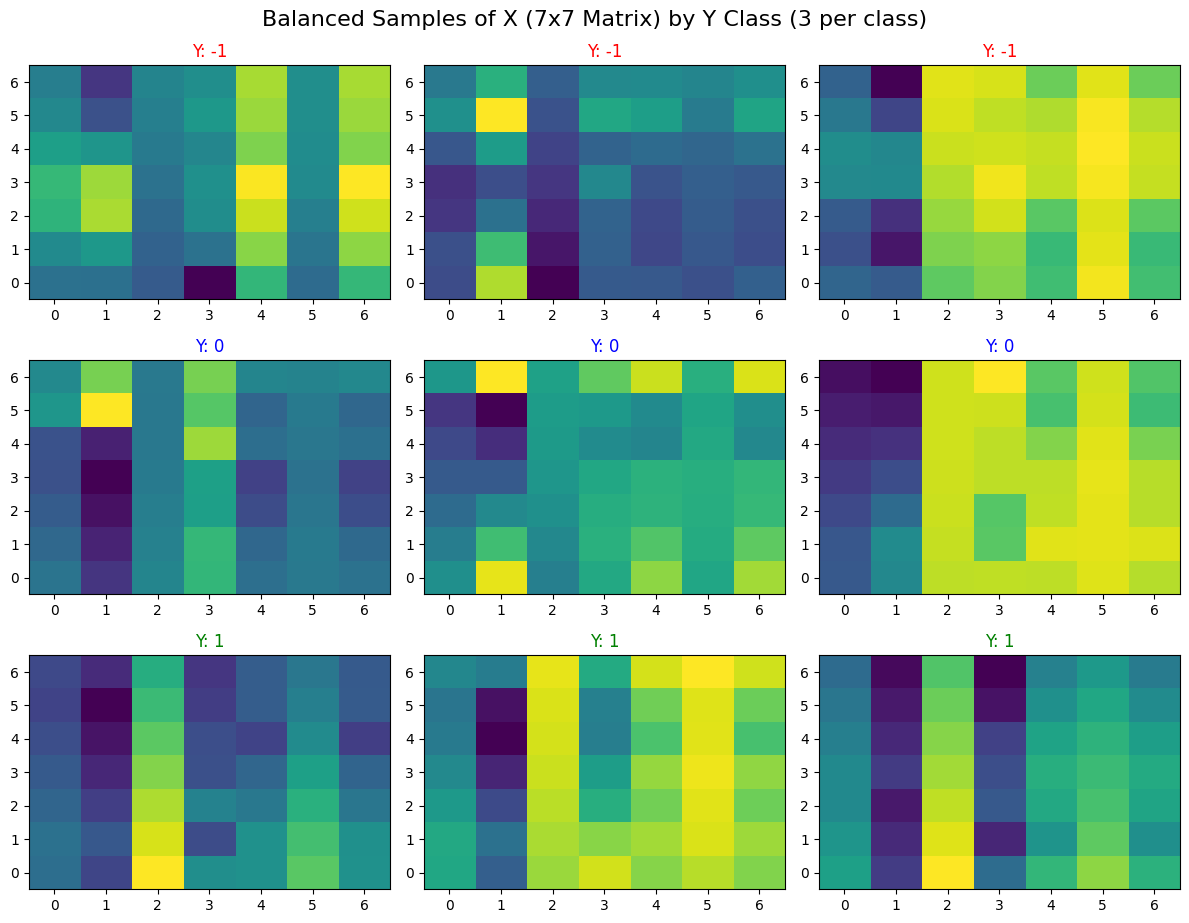

In [224]:
import numpy as np
import matplotlib.pyplot as plt

def plot_x_and_y_grid_balanced(X_data, y_data, num_plots_per_class=3):
    """
    在一張畫布上，以九宮格方式繪製指定數量的 X 數據（作為圖）及其對應的 Y 值，
    並根據 Y 的類別 (-1, 0, 1) 平衡地選擇樣本。

    Args:
        X_data (np.ndarray): X 數據，形狀應為 (樣本數, 15, 32)。
                             每個樣本是一個 15x32 的矩陣。
        y_data (np.ndarray): Y 數據，形狀應為 (樣本數,) 或 (樣本數, 1)。
                             每個樣本有一個對應的 Y 值。類別應為 -1, 0, 1。
        num_plots_per_class (int): 每個 Y 類別要繪製的樣本數量 (預設為 3)。
                                 總共會繪製 num_plots_per_class * 3 個圖。
    """
    # 確保數據是 NumPy 陣列
    X_data = np.asarray(X_data)
    y_data = np.asarray(y_data).flatten() # 確保 y 是扁平的

    # 定義目標類別
    target_classes = [-1, 0, 1]

    selected_indices = []

    print(f"嘗試從每個類別中選擇 {num_plots_per_class} 個樣本進行繪製。")

    for cls in target_classes:
        # 找到當前類別的所有索引
        class_indices = np.where(y_data == cls)[0]

        if len(class_indices) == 0:
            print(f"警告：數據中未找到類別 {cls} 的樣本。")
            continue

        # 如果該類別的樣本數少於所需，則全部選取；否則隨機選取指定數量
        if len(class_indices) <= num_plots_per_class:
            selected_indices.extend(class_indices)
            print(f"類別 {cls}：選取了 {len(class_indices)} 個樣本 (所有可用樣本)。")
        else:
            # 隨機選擇指定數量的樣本
            chosen = np.random.choice(class_indices, num_plots_per_class, replace=False)
            selected_indices.extend(chosen)
            print(f"類別 {cls}：選取了 {num_plots_per_class} 個樣本。")

    num_plots = len(selected_indices)
    if num_plots == 0:
        print("沒有足夠的樣本可以繪製。請檢查數據。")
        return

    # 計算九宮格的行數和列數
    rows = int(np.ceil(np.sqrt(num_plots)))
    cols = int(np.ceil(num_plots / rows))

    # 創建畫布和子圖
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten() # 將 axes 陣列扁平化，方便迭代

    for i, idx in enumerate(selected_indices):
        ax = axes[i]

        # 繪製 X 數據 (矩陣)
        im = ax.imshow(X_data[idx], cmap='viridis', origin='lower', aspect='auto')

        # 添加標題，顯示對應的 Y 值
        # 根據 Y 值設定標題顏色，使其更醒目
        title_color = 'green' if y_data[idx] == 1 else ('red' if y_data[idx] == -1 else 'blue')
        ax.set_title(f'Y: {int(y_data[idx])}', color=title_color, fontsize=12)

        # 移除座標軸刻度
        #ax.set_xticks([])
        #ax.set_yticks([])

    # 隱藏多餘的子圖 (如果 num_plots 不是完全填充網格)
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout() # 自動調整子圖間距
    n1,n2 = X_data[0].shape
    plt.suptitle(f'Balanced Samples of X ({n1}x{n2} Matrix) by Y Class ({num_plots_per_class} per class)',
                 y=1.02, fontsize=16)
    plt.show()
plot_x_and_y_grid_balanced(Xs,ys)

# Split data

In [225]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import Counter # 用於計算類別數量

# 假設 Xs, ys 已經定義且載入

# --- 數據分割 (與您提供的相同) ---
validation_split_ratio = 0.2
test_split_point = len(Xs) - test_set_size
Xs_main = Xs[:test_split_point]
ys_main = ys[:test_split_point]
Xs_test = Xs[test_split_point:]
ys_test = ys[test_split_point:]
main_samples = Xs_main.shape[0]
val_split_point = int(main_samples * (1 - validation_split_ratio))
Xs_train = Xs_main[:val_split_point]
ys_train = ys_main[:val_split_point]
Xs_val = Xs_main[val_split_point:]
ys_val = ys_main[val_split_point:]

print("Verification of splits:")
print(f"Total samples: {len(Xs)}")
print(f"split samples: {len(Xs_train)},{len(Xs_val)},{len(Xs_test)}")

# 將標籤 -1, 0, 1 轉換為 0, 1, 2
def transform_labels(labels):
    return labels + 1

ys_train_transformed = transform_labels(ys_train)
ys_val_transformed = transform_labels(ys_val)
ys_test_transformed = transform_labels(ys_test)

# --- 計算類別權重 (針對訓練集) ---
# 統計訓練集中每個類別的樣本數量
class_counts = Counter(ys_train_transformed.flatten()) # 使用 .flatten() 確保是 1D 陣列
print(f"訓練集原始類別分佈: {class_counts}")

# 確保所有三個類別 (0, 1, 2) 都被考慮，即使某些類別在訓練集中沒有出現
# 這對於 `class_weights` 的維度很重要
num_classes = 3
total_samples = len(ys_train_transformed)

# 計算每個類別的頻率
class_frequencies = {i: class_counts.get(i, 0) / total_samples for i in range(num_classes)}
print(f"訓練集類別頻率: {class_frequencies}")

# 計算類別權重：頻率越低，權重越高 (反比關係)
# 避免除以零的情況，如果某個類別完全沒有出現，可以給予一個較大的權重或預設值
class_weights = torch.zeros(num_classes, dtype=torch.float32)
for i in range(num_classes):
    if class_frequencies[i] > 0:
        class_weights[i] = 1.0 / class_frequencies[i]
    else:
        # 如果某個類別完全沒有樣本，給予一個很大的權重，但要小心可能導致不穩定
        # 或者考慮在數據集劃分時確保每個類別都有樣本
        class_weights[i] = 10.0 # 示例值，您可以根據情況調整
        print(f"警告：類別 {i} 在訓練集中沒有樣本，已給予預設權重。")

# 將權重歸一化，使其總和為 num_classes 或其他合適的值，以避免損失值過大或過小
class_weights = class_weights / class_weights.sum() * num_classes
print(f"計算出的類別權重: {class_weights}")

# 將 NumPy 陣列轉換為 PyTorch 張量
# 確保 X 數據的形狀是 (BATCH, 1, 15, 32)，因為 PyTorch CNN 通常期望這種通道優先的形狀
Xs_train_tensor = torch.tensor(Xs_train, dtype=torch.float32).unsqueeze(1)
ys_train_tensor = torch.tensor(ys_train_transformed, dtype=torch.long)

Xs_val_tensor = torch.tensor(Xs_val, dtype=torch.float32).unsqueeze(1)
ys_val_tensor = torch.tensor(ys_val_transformed, dtype=torch.long)

Xs_test_tensor = torch.tensor(Xs_test, dtype=torch.float32).unsqueeze(1)
ys_test_tensor = torch.tensor(ys_test_transformed, dtype=torch.long)

# 建立 TensorDataset
train_dataset = TensorDataset(Xs_train_tensor, ys_train_tensor)
val_dataset = TensorDataset(Xs_val_tensor, ys_val_tensor)
test_dataset = TensorDataset(Xs_test_tensor, ys_test_tensor)

# --- 配置 DataLoader ---
BATCH_SIZE = 64

# 選項1：加權損失 - 直接在 criterion 中使用 class_weights
# 您在訓練循環中直接使用這個 criterion 即可
# criterion = nn.CrossEntropyLoss(weight=class_weights.to(device)) # 在模型定義後，將權重移動到正確的設備

# 選項2：訓練集過採樣 - 使用 WeightedRandomSampler (需要創建 sample_weights)
# 步驟1: 為訓練集中的每個樣本計算其採樣權重
sample_weights = torch.zeros(len(train_dataset), dtype=torch.float32)
# 獲取每個樣本對應的類別權重
for i, label in enumerate(ys_train_tensor.squeeze()): # 注意：ys_train_tensor 仍然是 (N, 1) 需要 squeeze
    sample_weights[i] = class_weights[label] # 使用上面計算的 class_weights

# 步驟2: 創建 WeightedRandomSampler
# num_samples 設為 len(train_dataset) * 平均過採樣倍數 (例如 2, 3...)，讓每個 epoch 的樣本數增加
# 或者直接設為 len(train_dataset)，讓每個 epoch 的樣本數保持不變，但採樣頻率不同
# 這裡我們將 num_samples 設為訓練集的大小，但樣本會按權重抽樣
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights), # 每個 epoch 抽樣的總數，通常設為與數據集大小相同
    replacement=True # 允許重複抽樣，這是過採樣的關鍵
)

# 步驟3: 創建 DataLoader，並使用 sampler
train_loader_weighted_sampling = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)

# 普通的 DataLoader (用於驗證和測試，或不使用過採樣時的訓練)
train_loader_normal = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"訓練數據形狀: {Xs_train_tensor.shape}, 標籤形狀: {ys_train_tensor.shape}")
print(f"驗證數據形狀: {Xs_val_tensor.shape}, 標籤形狀: {ys_val_tensor.shape}")
print(f"測試數據形狀: {Xs_test_tensor.shape}, 標籤形狀: {ys_test_tensor.shape}")

Verification of splits:
Total samples: 2998
split samples: 2326,582,90
訓練集原始類別分佈: Counter({np.int64(1): 889, np.int64(2): 812, np.int64(0): 625})
訓練集類別頻率: {0: 0.2687016337059329, 1: 0.382201203783319, 2: 0.34909716251074807}
計算出的類別權重: tensor([1.2132, 0.8529, 0.9338])
訓練數據形狀: torch.Size([2326, 1, 7, 7]), 標籤形狀: torch.Size([2326, 1])
驗證數據形狀: torch.Size([582, 1, 7, 7]), 標籤形狀: torch.Size([582, 1])
測試數據形狀: torch.Size([90, 1, 7, 7]), 標籤形狀: torch.Size([90, 1])


# 開始建模 PyTorch 股價數據圖像分類訓練流程

# 模型定義

In [226]:
class StockPriceCNN(nn.Module):
    def __init__(self, input_channels=Xs.shape[1], input_sequence_length=Xs.shape[2], num_classes=3):
        super(StockPriceCNN, self).__init__()
        # Conv1d: input_channels is now 10, output_channels 32, kernel_size 3
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()

        # Conv1d: input_channels 32, output_channels 64, kernel_size 3
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

        # Flattened features calculation
        # Output channels from conv2 (64) * sequence_length (which remains input_sequence_length due to padding)
        self.flattened_features = 64 * input_sequence_length

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_features, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Expected input x shape: (batch_size, input_channels, input_sequence_length)
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))

        # Flatten
        x = x.view(-1, self.flattened_features)

        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 實例化模型
model = StockPriceCNN(num_classes=3)
print(model)

# 檢查是否有 GPU 可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"模型將在 {device} 上運行")

StockPriceCNN(
  (conv1): Conv1d(7, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu1): ReLU()
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu2): ReLU()
  (fc1): Linear(in_features=448, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)
模型將在 cpu 上運行


# 使用加權損失訓練處理類別不平衡

In [227]:
# --- 定義損失函數和優化器 (使用加權損失) ---
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練參數
NUM_EPOCHS = 500
PATIENCE = 20
max_val_acc = 0.0 # 更改為追蹤最大驗證準確度
epochs_no_improve = 0
best_model_path = "best_stock_price_cnn_model_weighted_loss.pth" # 更改保存檔名

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("\n開始訓練 (使用加權損失)...")
for epoch in range(NUM_EPOCHS):
    # 訓練階段
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # 使用正常的 train_loader_normal，因為權重已經在 criterion 中處理了
    for inputs, labels in train_loader_normal:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze() # 確保 labels 是 1D 張量
        inputs = inputs.squeeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader_normal.dataset)
    epoch_train_acc = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # 驗證階段
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.squeeze() # 確保 labels 是 1D 張量
            inputs = inputs.squeeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

    # 早停法邏輯 (根據驗證集準確度)
    if epoch_val_acc > max_val_acc: # 檢查驗證準確度是否改善
        max_val_acc = epoch_val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"    驗證準確度改善 ({max_val_acc:.4f})，保存模型到 {best_model_path}")
    else:
        epochs_no_improve += 1
        print(f"    驗證準確度沒有改善，耐心值: {epochs_no_improve}/{PATIENCE}")
        if epochs_no_improve >= PATIENCE:
            print(f"    早停！驗證準確度在 {PATIENCE} 個 epoch 內沒有改善。")
            break

print("訓練完成！")


開始訓練 (使用加權損失)...
Epoch 1/500 - Train Loss: 1.0880, Train Acc: 0.3813 | Val Loss: 1.0985, Val Acc: 0.3076
    驗證準確度改善 (0.3076)，保存模型到 best_stock_price_cnn_model_weighted_loss.pth
Epoch 2/500 - Train Loss: 1.0704, Train Acc: 0.4359 | Val Loss: 1.1090, Val Acc: 0.3179
    驗證準確度改善 (0.3179)，保存模型到 best_stock_price_cnn_model_weighted_loss.pth
Epoch 3/500 - Train Loss: 1.0565, Train Acc: 0.4665 | Val Loss: 1.1073, Val Acc: 0.3419
    驗證準確度改善 (0.3419)，保存模型到 best_stock_price_cnn_model_weighted_loss.pth
Epoch 4/500 - Train Loss: 1.0566, Train Acc: 0.4587 | Val Loss: 1.1091, Val Acc: 0.3591
    驗證準確度改善 (0.3591)，保存模型到 best_stock_price_cnn_model_weighted_loss.pth
Epoch 5/500 - Train Loss: 1.0493, Train Acc: 0.4531 | Val Loss: 1.1191, Val Acc: 0.3179
    驗證準確度沒有改善，耐心值: 1/20
Epoch 6/500 - Train Loss: 1.0457, Train Acc: 0.4579 | Val Loss: 1.0997, Val Acc: 0.3488
    驗證準確度沒有改善，耐心值: 2/20
Epoch 7/500 - Train Loss: 1.0385, Train Acc: 0.4686 | Val Loss: 1.1052, Val Acc: 0.3608
    驗證準確度改善 (0.3608)，保存模型到 bes

# 訓練過程記錄

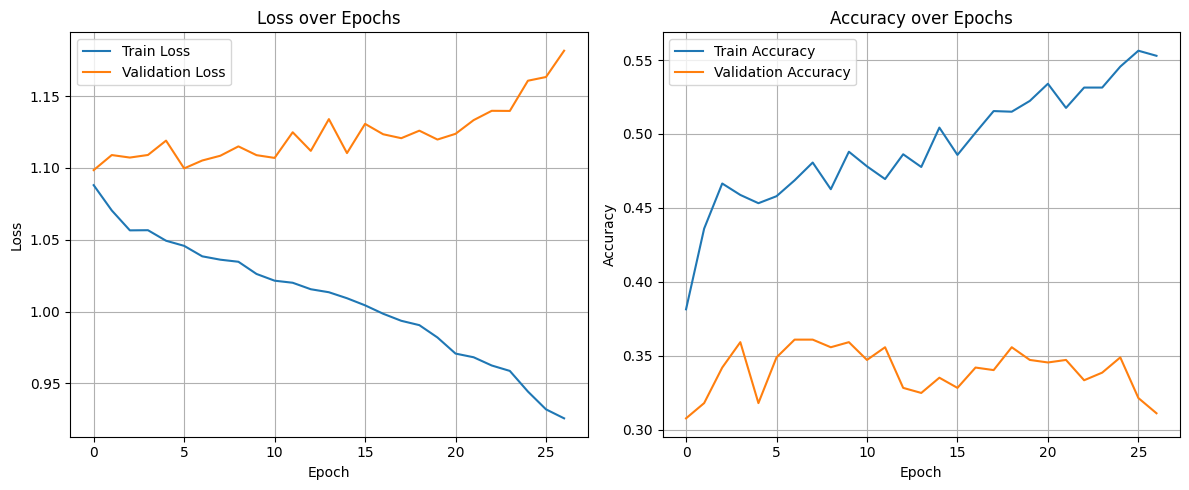

In [228]:
# 繪製訓練過程圖
plt.figure(figsize=(12, 5))

# 損失圖
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 準確度圖
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 測試報告

In [229]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

# ... (您的數據載入、模型定義、訓練流程等前置程式碼) ...

# 載入最佳模型 (保持不變)
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print(f"\n已載入最佳模型：{best_model_path}")
else:
    print("\n未找到最佳模型，將使用最後一個 epoch 的模型進行測試。")

model.eval() # 設定模型為評估模式
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze() # 確保 labels 是 1D 張量
        inputs = inputs.squeeze(1)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 將轉換後的標籤 (0, 1, 2) 轉換回原始標籤 (-1, 0, 1) 以便報告
original_labels_mapping = {0: -1, 1: 0, 2: 1}
all_preds_original = [original_labels_mapping[int(p)] for p in all_preds]
all_labels_original = [original_labels_mapping[int(l)] for l in all_labels]

print("\n--- 測試集評估 ---")

# 混淆矩陣 (保持不變)
cm = confusion_matrix(all_labels_original, all_preds_original, labels=[-1, 0, 1])
print("\n混淆矩陣:")
print(cm)

# 分類報告 (關鍵修改點)
# 確保 labels 參數包含所有可能的類別
class_report = classification_report(
    all_labels_original,
    all_preds_original,
    labels=[-1, 0, 1], # <--- 添加這行！
    target_names=['-1', '0', '1'],
    digits=4,
    zero_division='warn' # 或者 '0' 或 None，根據您希望如何處理零除問題
)
print("\n分類報告:")
print(class_report)


已載入最佳模型：best_stock_price_cnn_model_weighted_loss.pth

--- 測試集評估 ---

混淆矩陣:
[[ 4 16  7]
 [ 5 30  6]
 [ 5 13  4]]

分類報告:
              precision    recall  f1-score   support

          -1     0.2857    0.1481    0.1951        27
           0     0.5085    0.7317    0.6000        41
           1     0.2353    0.1818    0.2051        22

    accuracy                         0.4222        90
   macro avg     0.3432    0.3539    0.3334        90
weighted avg     0.3749    0.4222    0.3820        90



# 回測 看過的資料和沒看過的資料

[*********************100%***********************]  1 of 1 completed

Calculating Finta indicators for periods: [6, 20]


Calculating Finta single-call/complex indicators:
Calculating custom PZO indicators for periods: [6, 20]


100%|██████████| 2998/2998 [00:08<00:00, 339.91it/s]


準備完成
Aligned aligned_close_prices.shape: (2998,)
Aligned signals.shape: (2998,)

--- Backtesting Your Strategy ---
Initial Capital: 100000.00
Final Asset Value (Your Strategy): 46699934.94
Total Return (Your Strategy): 46599.93%

--- Buy and Hold Strategy ---
Initial Capital: 100000.00
Final Asset Value (Buy and Hold): 4333274.93
Total Return (Buy and Hold): 4233.27%


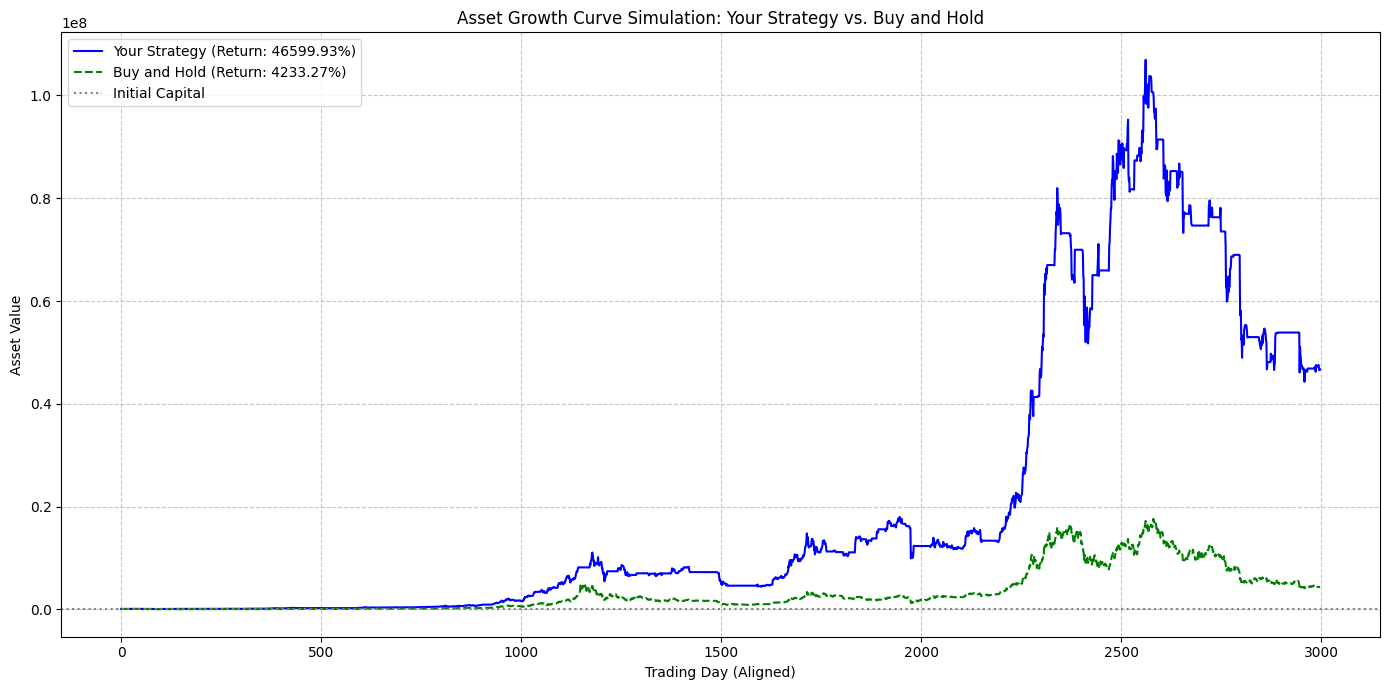

[*********************100%***********************]  1 of 1 completed

2022-12-30 00:00:00 1
Calculating Finta indicators for periods: [6, 20]


Calculating Finta single-call/complex indicators:
Calculating custom PZO indicators for periods: [6, 20]


100%|██████████| 895/895 [00:03<00:00, 263.34it/s]


準備完成
Aligned aligned_close_prices.shape: (895,)
Aligned signals.shape: (895,)

--- Backtesting Your Strategy ---
Initial Capital: 100000.00
Final Asset Value (Your Strategy): 224249.84
Total Return (Your Strategy): 124.25%

--- Buy and Hold Strategy ---
Initial Capital: 100000.00
Final Asset Value (Buy and Hold): 469740.91
Total Return (Buy and Hold): 369.74%


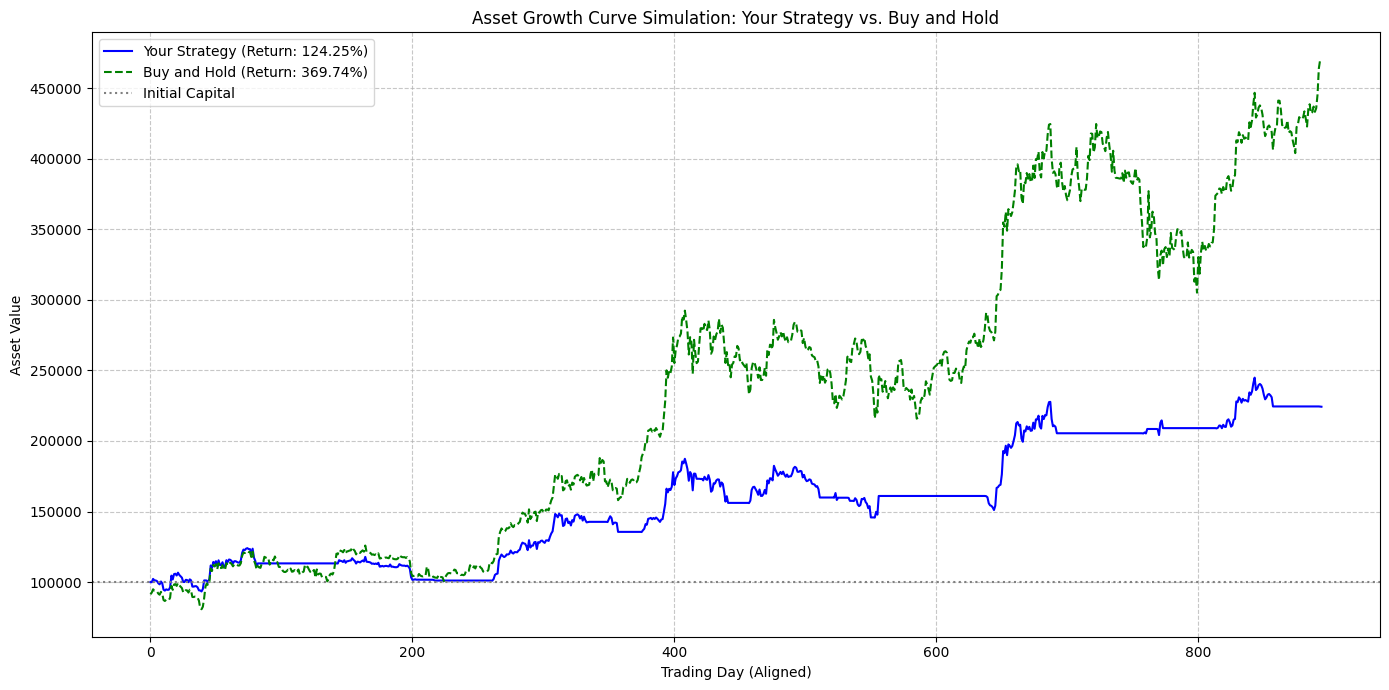

2025-07-12 00:00:00 2


In [230]:
def backtest(startdate,enddate,model=model):
  df = load_data(y_symbol,startdate,enddate)#載入數據
  df = add_triple_barrier_signal(df,漲幅,跌幅,持有時間)
  df_with_indicators = generate_finta_indicators(df, periods=[6,20])#做技術指標
  df_with_indicators,scaler_trained = preprocess_indicators(df_with_indicators, scaler=joblib.load('/content/trained_scaler.joblib'), fit_scaler=False)#標準化
  Xs,ys,indexs = create_X_y_pair(df_with_indicators)#做成圖像給模型看
  Xs_tensor = torch.tensor(Xs, dtype=torch.float32).unsqueeze(1)#pytorch格式
  Xs_tensor = Xs_tensor.squeeze(1)
  model = model.eval()#模型
  y_pred = model(Xs_tensor).argmax(dim=1).cpu().numpy()#模型預測
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt

  # --- 2. Align Data ---
  # Take the last len(y_pred) rows from df['Close']
  aligned_close_prices = df['Close'].tail(len(y_pred)).reset_index(drop=True)

  # Convert y_pred to a Pandas Series for easier handling
  signals = pd.Series(y_pred, name='Signal')

  print(f"Aligned aligned_close_prices.shape: {aligned_close_prices.shape}")
  print(f"Aligned signals.shape: {signals.shape}")

  # Confirm lengths match
  assert len(aligned_close_prices) == len(signals), "Aligned data lengths do not match!"

  # Merge aligned data into a new DataFrame for convenience
  backtest_df = pd.DataFrame({
      'Close': aligned_close_prices,
      'Signal': signals
  })

  # --- 3. Simulate Backtest: Your Strategy ---
  initial_capital = 100000  # Initial capital
  shares = 0               # Number of shares held
  capital = initial_capital # Current cash
  strategy_asset_value_history = [initial_capital] # Record asset value changes

  # Transaction cost (optional, adjust based on your actual broker fees)
  transaction_cost_rate = 0.001 # 0.1% transaction fee per trade

  print("\n--- Backtesting Your Strategy ---")
  for i in range(1, len(backtest_df)):
      current_close = backtest_df['Close'].iloc[i]
      signal = backtest_df['Signal'].iloc[i]

      if signal == 2:  # Buy signal
          if capital > 0: # Ensure there's capital to buy
              # Buy as many shares as possible, ignoring minimum lot size for simplicity
              buyable_shares = (capital * (1 - transaction_cost_rate)) // current_close
              if buyable_shares > 0:
                  shares += buyable_shares
                  capital -= buyable_shares * current_close # Deduct cost
                  capital -= buyable_shares * current_close * transaction_cost_rate # Deduct transaction fee
                  # print(f"Date {i}: BUY {int(buyable_shares)} shares @ {current_close:.2f}, Remaining Capital: {capital:.2f}, Held Shares: {int(shares)}")

      elif signal == 0: # Sell signal
          if shares > 0: # Ensure there are shares to sell
              capital += shares * current_close # Add proceeds from sale
              capital -= shares * current_close * transaction_cost_rate # Deduct transaction fee
              # print(f"Date {i}: SELL {int(shares)} shares @ {current_close:.2f}, Remaining Capital: {capital:.2f}, Held Shares: 0")
              shares = 0 # Sell all held shares

      # Calculate current total asset value
      current_asset_value = capital + shares * current_close
      strategy_asset_value_history.append(current_asset_value)

  # Final asset value for your strategy
  final_strategy_asset_value = capital + shares * backtest_df['Close'].iloc[-1]
  strategy_return = ((final_strategy_asset_value - initial_capital) / initial_capital * 100)

  print(f"Initial Capital: {initial_capital:.2f}")
  print(f"Final Asset Value (Your Strategy): {final_strategy_asset_value:.2f}")
  print(f"Total Return (Your Strategy): {strategy_return:.2f}%")

  # --- 4. Simulate Backtest: Buy and Hold Strategy ---
  # Initial investment in shares at the first available close price
  buy_hold_initial_shares = initial_capital // backtest_df['Close'].iloc[0]
  buy_hold_asset_value_history = []

  for i in range(len(backtest_df)):
      current_close = backtest_df['Close'].iloc[i]
      buy_hold_asset_value_history.append(buy_hold_initial_shares * current_close)

  # Final asset value for Buy and Hold
  final_buy_hold_asset_value = buy_hold_initial_shares * backtest_df['Close'].iloc[-1]
  buy_hold_return = ((final_buy_hold_asset_value - initial_capital) / initial_capital * 100)

  print("\n--- Buy and Hold Strategy ---")
  print(f"Initial Capital: {initial_capital:.2f}")
  print(f"Final Asset Value (Buy and Hold): {final_buy_hold_asset_value:.2f}")
  print(f"Total Return (Buy and Hold): {buy_hold_return:.2f}%")


  # --- 5. Plot Asset Growth Curves ---
  plt.figure(figsize=(14, 7))
  plt.plot(strategy_asset_value_history, label=f'Your Strategy (Return: {strategy_return:.2f}%)', color='blue')
  plt.plot(buy_hold_asset_value_history, label=f'Buy and Hold (Return: {buy_hold_return:.2f}%)', color='green', linestyle='--')
  plt.axhline(y=initial_capital, color='gray', linestyle=':', label='Initial Capital')

  plt.title('Asset Growth Curve Simulation: Your Strategy vs. Buy and Hold')
  plt.xlabel('Trading Day (Aligned)')
  plt.ylabel('Asset Value')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.show()
  print(df['Close'].tail(1).index[0],y_pred[-1])
# 單純抽換資料看看差別
backtest(startdate,enddate)
backtest(enddate,datetime.now())